# CSII 2024 Exercise 09: Q-Parametrization and Frequency weights

© 2024 ETH Zurich, Jacques Bianchi, Sofia Talleri, Stephan König, Paolo Petri, Joël Gmür, Dejan Milojevic, Niclas Scheuer; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

Reference:
- [Python Control Systems Library](https://python-control.readthedocs.io/en/0.9.3.post2/steering.html)
- Karl J. Astrom and Richard M. Murray 23 Jul 2019


## Exercise 1: Q-Parametrization for CS2-Bot Controller Design
Recall the CS2-Bot first used in PS03, where the advantages of state-feedback were demonstrated. In PS04 we added a state-estimater and introduced optimal control for it in PS05. In this problem set the task is to parametrize all stabilizing controllers using a Q-parametrization.

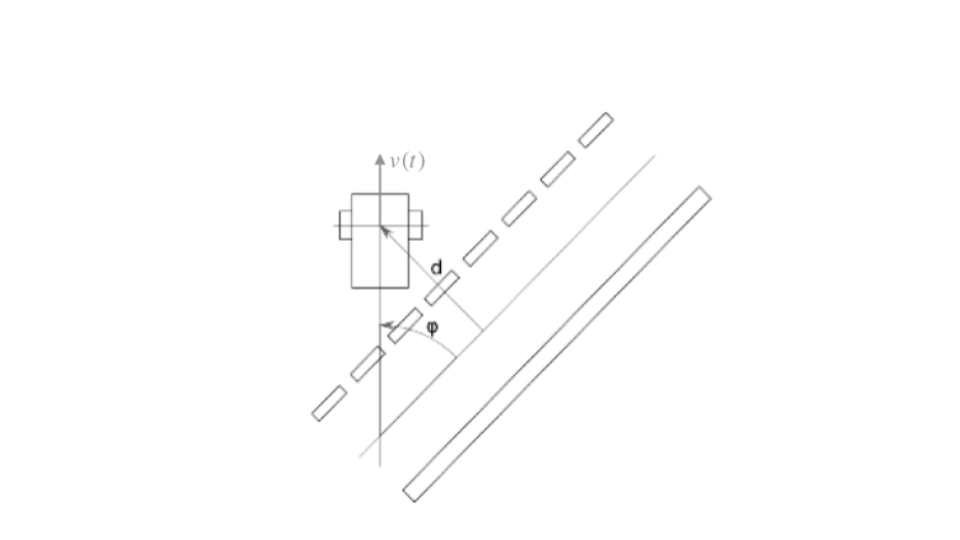

-------
## Installation
As usual we first install the required library.





In [104]:
# Install the required python library with pip
%pip install cs2solutions

------
## Python Packages
We use the following Python libraries which need to be imported. If you have no experience with the [NumPy](https://numpy.org/) library, read the documentation and do some tutorials. It is very important for matrix operations in Python.



In [105]:
# Import the required python libraries
from cs2solutions import duckiebot
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import control as ct

## Dynamics

The nonlinear dynamics and the output of the CS2-Bot are defined in the next cell.

In [106]:
unicycle_update = duckiebot.unicycle_update
unicycle_output = duckiebot.unicycle_output

View function definitions by right-clicking and using 'Go to definition (F12)'. Alternatively, you can view the function definitions on [GitHub](https://github.com/idsc-frazzoli/cs2solutions/blob/59ad007bfeabdaed54f2b620ccb969f37c56104f/src/cs2solutions/duckiebot.py#L13-L24).

Various plotting functions are defined here: [GitHub](https://github.com/idsc-frazzoli/cs2solutions/blob/59ad007bfeabdaed54f2b620ccb969f37c56104f/src/cs2solutions/duckiebot.py#L27-L258)

## Parameters and Reference Track

We set a default CS2-Bot velocity and generate the nonlinear system using the `control` library.

In [107]:
# Default CS2 Bot velocity in m/s
bot_params={'velocity': 0.1, 'max_omega': 0.05}
# Define the CS2 Bot's steering dynamics as an input/output system
bot = ct.NonlinearIOSystem(
    duckiebot.unicycle_update, duckiebot.unicycle_output, states=3, name='bot',
    inputs=('v', 'w'), outputs=('x', 'y'), params=bot_params)

v0 = bot_params['velocity']

We define a reference track that we want to follow. If you want to test an easy track, set `curve_difficulty_levels[0]`. For a hard track set `curve_difficulty_levels[1]`. If you want to create your own track, set `curve_difficulty_levels[2]` and change `w_curvy` after the `else` line. The reference line is generated by simulating some given control inputs for a certain time. We keep the velocity input `v_curvy` constant and calculate a forced angluar velocity `w_curvy`.

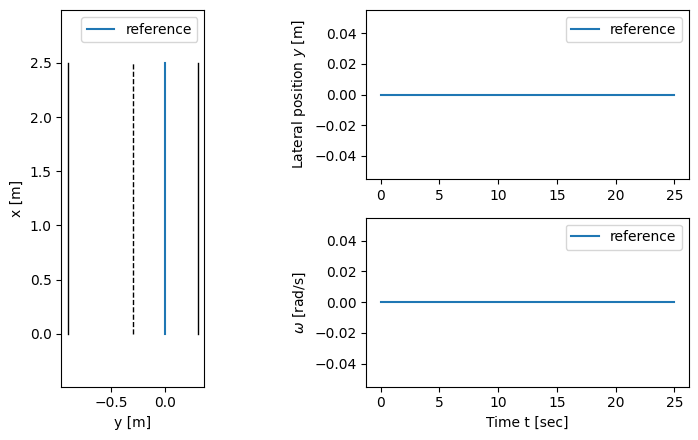

In [108]:
# Control inputs
curve_difficulty_levels = ['easy', 'hard', 'straignt']
curve_difficulty = curve_difficulty_levels[2]
T_curvy = np.linspace(0, 25, 500)
v_curvy = v0*np.ones(T_curvy.shape)
if curve_difficulty=='easy':
    w_curvy = 0.025*np.sin(T_curvy*np.pi/50)
elif curve_difficulty=='hard':
    w_curvy = 0.2*np.sin(T_curvy)*np.cos(4*T_curvy) + 0.025*np.sin(T_curvy*np.pi/10)
else:
    w_curvy = np.zeros(T_curvy.shape)
u_curvy = [v_curvy, w_curvy]
X0_curvy = [0, 0, 0]

# Simulate the system + estimator
t_curvy, y_curvy, x_curvy = ct.input_output_response(
    bot, T_curvy, u_curvy, X0_curvy, params=bot_params, return_x=True)

duckiebot.plot_track(y_curvy[0], y_curvy[1], x_curvy[2], t_curvy, w_curvy)
y_ref = x_curvy[1]
r = np.expand_dims(y_ref, axis=0)
t = T_curvy

## Linearization, Normalization and State Space Represenation

In the next cell we show you how to linearize and normalize the system using the `control` library. As shown in the class, we use $u_1=v_0$ as a constant for simplicity.


In [109]:
# Define the lateral dynamics as a subset of the full CS2 Bot steering dynamics
lateral = ct.NonlinearIOSystem(
    lambda t, x, u, params: duckiebot.unicycle_update(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    lambda t, x, u, params: duckiebot.unicycle_output(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    states=2, name='lateral', inputs=('w'), outputs=('y')
)

# Compute the linearization at velocity v0 = 0.1 m/sec
lateral_linearized = ct.linearize(lateral, [0, 0], [0], params=bot_params)

# Save the system matrices for later use
A = lateral_linearized.A
B = lateral_linearized.B
C = lateral_linearized.C
D = lateral_linearized.D
print("A =", A)
print("B =", B)
print("C =", C)
print("D =", D)

A = [[0.  0.1]
 [0.  0. ]]
B = [[0.]
 [1.]]
C = [[1. 0.]]
D = [[0.]]


## Adding Noise

A certain type of noise will be affecting the system. Choose the noise type which you would like to test in `index_noise`, where you change the integer number to the noise index you want test. Index `index_noise = 0` corresponds to a constant noise (i.e. constant shift of the states), index `index_noise = 1` is a random uniform noise, `index_noise = 2` is white noise and `index_noise = 3` no noise.

In [110]:
noise_type = ['const', 'uniform', 'white_noise', 'no_noise']
index_noise = 1
noise = noise_type[index_noise]
if noise == 'const':
    n = np.ones(r.shape)*0.5
elif noise=='uniform':
    n = np.random.uniform(low=-0.1, high=0.1, size=r.shape)
elif noise=='white_noise':
    Rw_lat = np.diag([0.001])
    n = ct.white_noise(t, Rw_lat)
else:
    n = np.zeros(r.shape)
U = np.concatenate((r, n))

## Implementing Q-Parametrization

Recall the structure of the Dynamic Output Feedback Compensator (DOFB) from lecture 05. The following block-diagram shows how Q-parametrization is introduced. 
The signal $v$ is the output and the signal $h$ is the input to $Q$. In lecture 05 we observed that the reference $r$ does not affect the innovation $ \eta = y - \hat{y} $. This implies, that $v$ also has no influence on $h$ and thus the total system is stable if the parameter $Q$ is stable. This is assuming that the controller and the observer are stable on their own already. 

In the following tasks we will introduce the Q-parametrization to the DOFB from lecture 05.

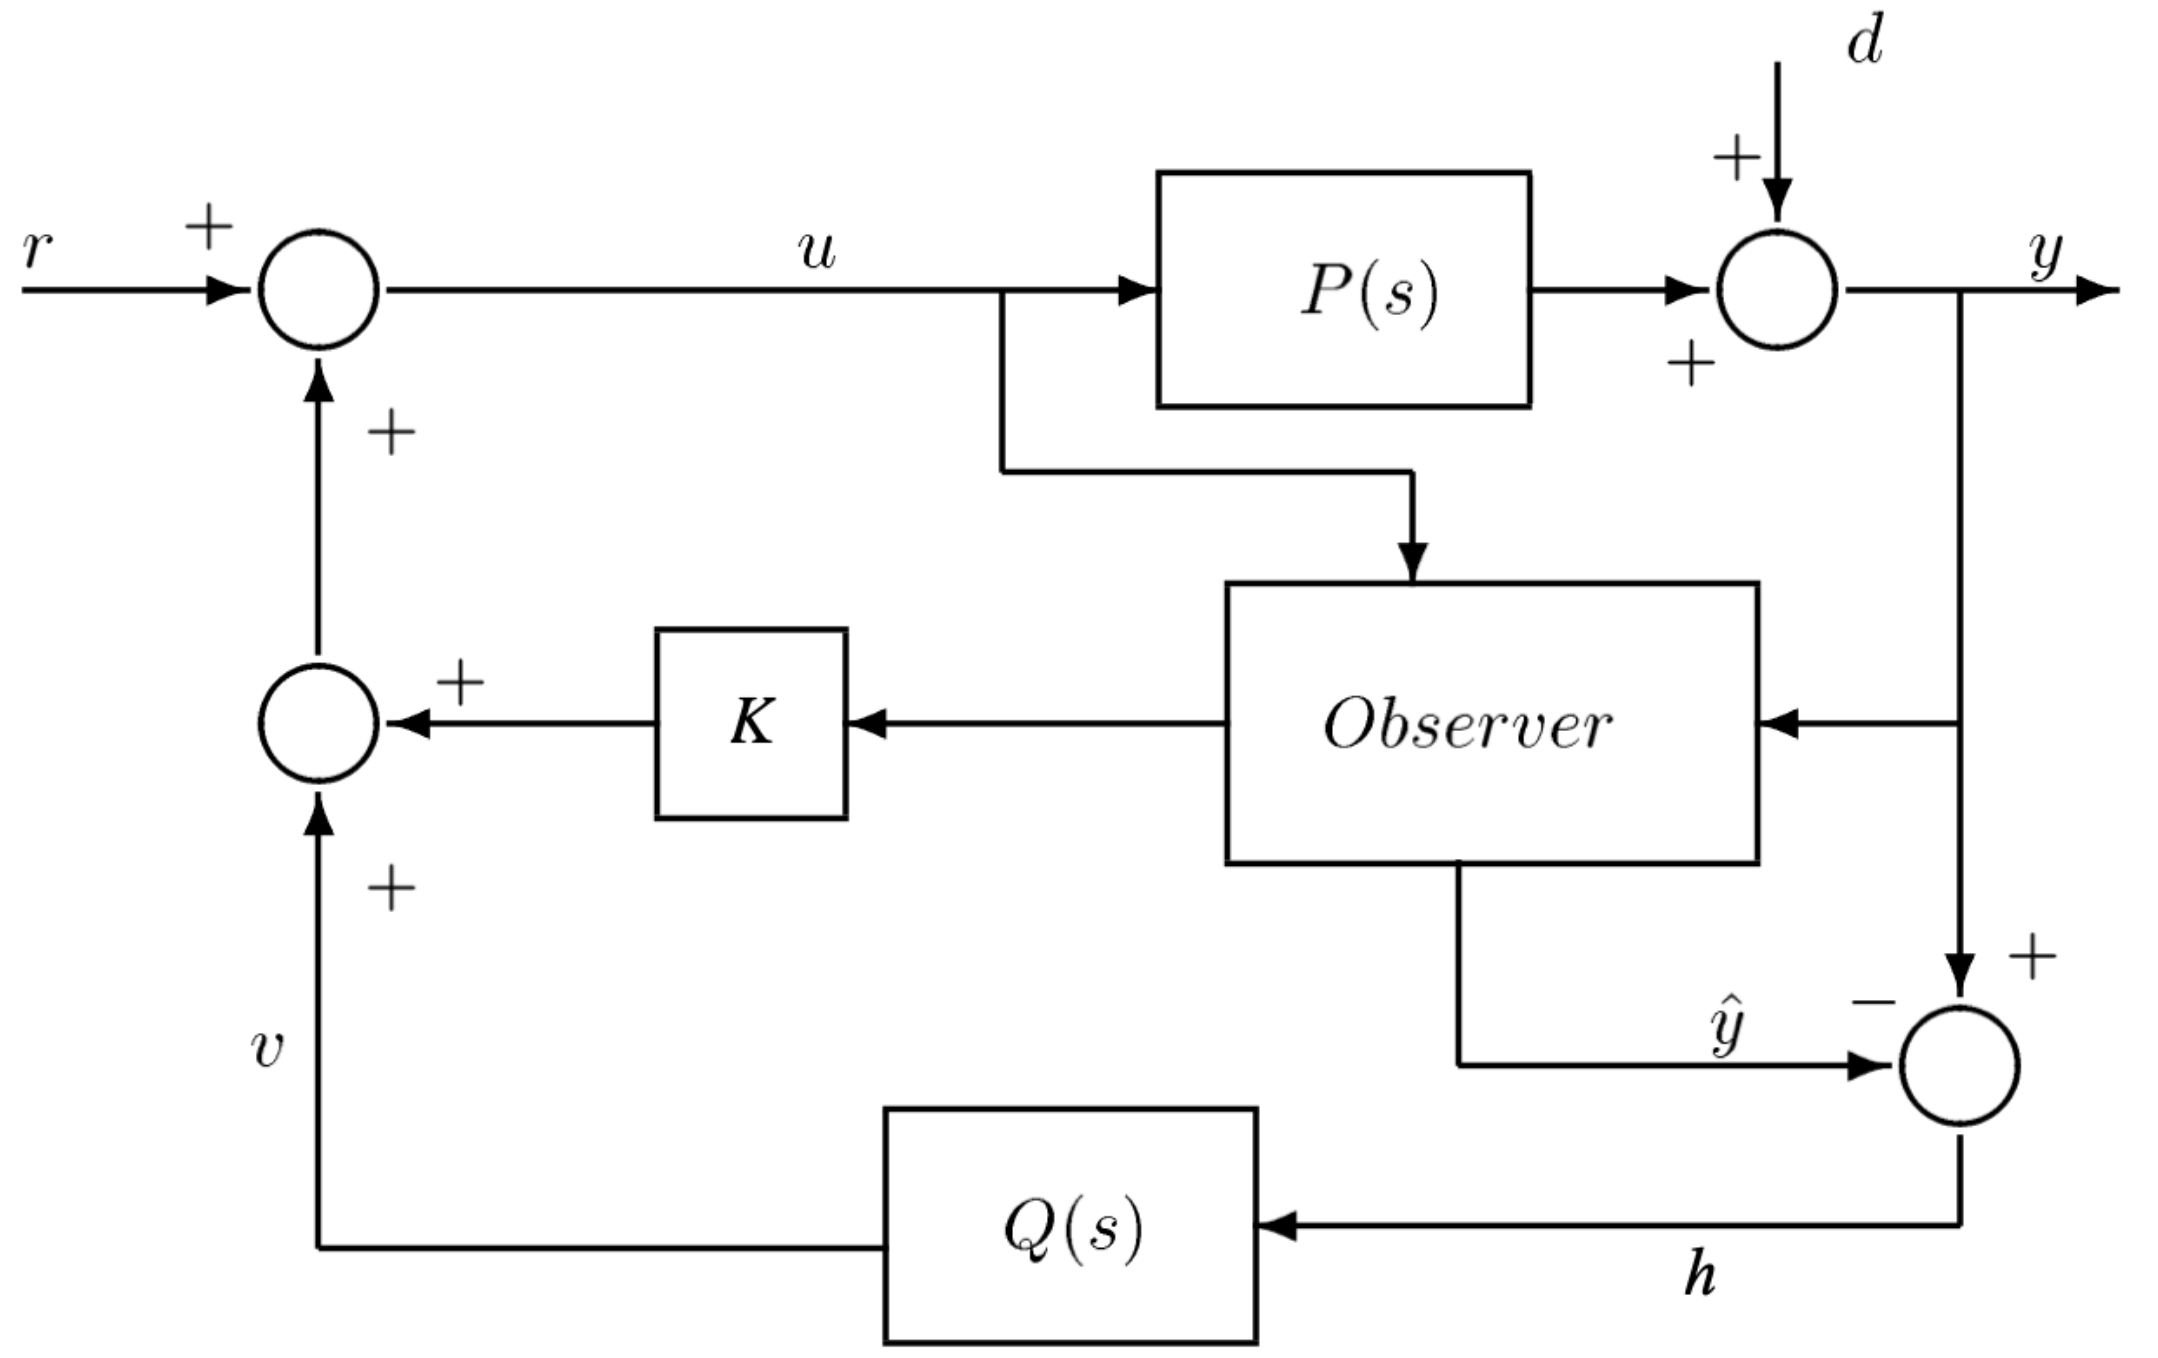




## Task 1.1 
Before we can introduce a $Q$-block, we need to find the transfer-function of the plant $P$. For this you can use the already computed system matrices A, B, C, D.
Also, we need to set the state-feedback gain $K$ as well as the observer gain $L$.
You can use `ct.acker` to place the poles.

In [111]:
# Define the transfer function of the Plant P
P = ct.ss2tf(A,B,C,D)

# Setting the poles of the controller and observer
poles_controller = [-0.1, -0.1] # Try to change it
poles_observer = [-1, -1] # Try to change it

# Compute the controller and observer gains
K = ct.acker(A, B, poles_controller)
L = ct.acker(A.T, C.T, poles_observer).T

## Exercise 1.2
Next, we will need to define the Q-block. As seen in the lecture, Q needs to be stable, proper and rational.
Define the transfer function `Q` and the state-space representation `sys_q`. Print the poles to double check stability of Q.

Start with the transfer function
$$ Q = \frac{s}{s+1} .$$
After you solved all parts of the exercise, you can come back and change the transfer function to see the effect on the stabilizing controller.

In [112]:
# Define the transfer function for the parameter Q
Q = ct.TransferFunction([1, 0], [1, 1],name='Q')

# Compute the state-space representation of Q
sys_q = ct.tf2ss(Q)

# Compute the poles of Q and print the result
qpoles = ct.poles(Q)
print(qpoles)

[-1.+0.j]


## Exercise 1.3
Now that we have all the components of the system, we can compute the state-space representation of the full closed loop system.
We receive the total state vector of the system by stacking the states of the Plant $P$, the states of the $Q$-Block and the innovation $\eta$:
$$ x_{cl} = \left [ \begin{array}{c} x \\ x_{Q} \\ \eta \end{array} \right]. $$

Recall that the we can choose the A-matrices of the state-feedback subsystem and the observer subsystem with pole placement independently. This also applies to the $Q$-Block. Thus you can compute the matrices for these subsystems individually before stacking them.

Compute the A-submatrices of the state-feedback and observer system, $ABK$ and $ALC$ respectively.

In [113]:
# Find the A-matrix of the state-feedback subsystem
ABK = A - B @ K

# Find the A matrix of the observer subsystem
ALC = A - L @ C

## Exercise 1.4
Calculate the total closed-loop system matrices $A_{cl}$, $B_{cl}$, $C_{cl}$, $D_{cl}$. You can do this by concatenating the different terms that appear in the total closed loop system.

Hint: You will also need the terms $BC_Q$, $BK$ and $B_QC$.

In [118]:
# Define the three additional matrices we need
BCQ = B @ sys_q.C
BK = B @ K
BQC = sys_q.B @ C

# Find the A matrix of the full closed loop system
#Concatenate the evaluated submatrices to find the first row of the total A matrix
Acl_1 = np.concatenate((ABK, BCQ, -BK), axis=1)

# Define the shape of the zeros-matrix at position (2,1)
zeros_21 = np.zeros((sys_q.A.shape[0], ABK.shape[1]))

#Concatenate the evaluated submatrices to find the second row of the total A matrix
Acl_2 = np.concatenate((zeros_21, sys_q.A, BQC), axis=1)

# Define the shape of the zeros-matrix at position (3, 1)
zeros_31 = np.zeros((ABK.shape[0], ABK.shape[1]))

# Define the shape of the zeros-matrix at position (3, 2)
zeros_32 = np.zeros((A.shape[0], sys_q.A.shape[1]))

#Concatenate the evaluated submatrices to find the third row of the total A matrix
Acl_3 = np.concatenate((zeros_31, zeros_32, ALC), axis=1)

# Concatenate the three evaluated rows to find the total A matrix
Acl = np.concatenate((Acl_1, Acl_2, Acl_3), axis=0)



# Find the B matrix of the full closed loop system
# Find the components of the first row of the total B matrix
B_11 = B
B_12 = np.zeros((ABK.shape[0], 1))

# Find the first row of the total B matrix
B_1 = np.concatenate((B_11, B_12), axis=1)

# Find the components of the first row of the total B matrix
B_21 = np.zeros((ABK.shape[0] + sys_q.A.shape[0], 1))
B_22 = np.ones((ABK.shape[0] + sys_q.A.shape[0], 1))

# Find the second row of the total B matrix
B_2 = np.concatenate((B_21, B_22), axis=1)

# Concatenate the three evaluated rows to find the total B matrix
Bcl = np.concatenate((B_1, B_2), axis=0)



# Find the C matrix of the full closed loop system
C_1 = np.zeros((1, Acl.shape[0]))
C_1[0][0] = 1
C_2 = np.concatenate((np.zeros((C.shape)), sys_q.C, np.zeros((C.shape))), axis=1)

# Concatenate the two evaluated rows to find the total C matrix
Ccl = np.concatenate((C_1, C_2), axis=0)



# Find the D matrix of the full closed loop system
Dcl = np.zeros((2, 2))



# Define the full closed loop system
syscl = ct.ss(Acl, Bcl, Ccl, Dcl)

# Print the full closed loop system
print(syscl)

<StateSpace>: sys[138]
Inputs (2): ['u[0]', 'u[1]']
Outputs (2): ['y[0]', 'y[1]']
States (5): ['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]']

A = [[  0.    0.1   0.   -0.   -0. ]
     [ -0.1  -0.2  -1.   -0.1  -0.2]
     [  0.    0.   -1.    1.    0. ]
     [  0.    0.    0.   -2.    0.1]
     [  0.    0.    0.  -10.    0. ]]

B = [[0. 0.]
     [1. 0.]
     [0. 1.]
     [0. 1.]
     [0. 1.]]

C = [[ 1.  0.  0.  0.  0.]
     [ 0.  0. -1.  0.  0.]]

D = [[0. 0.]
     [0. 0.]]



The next code snippet simulates the response of the total system.

In [115]:
x_0 = np.zeros((Acl.shape[0],))
x_0[0] = 0.2 #define initial position

t, yout, xf = ct.forced_response(syscl, T_curvy, U, X0 = x_0, return_x=True)
yf = yout[0]
v = yout[1]
omegaf = - K @ xf[:2] + y_ref + v
omegaf = omegaf[0]

Finally, we can visualize the performance of the system. 

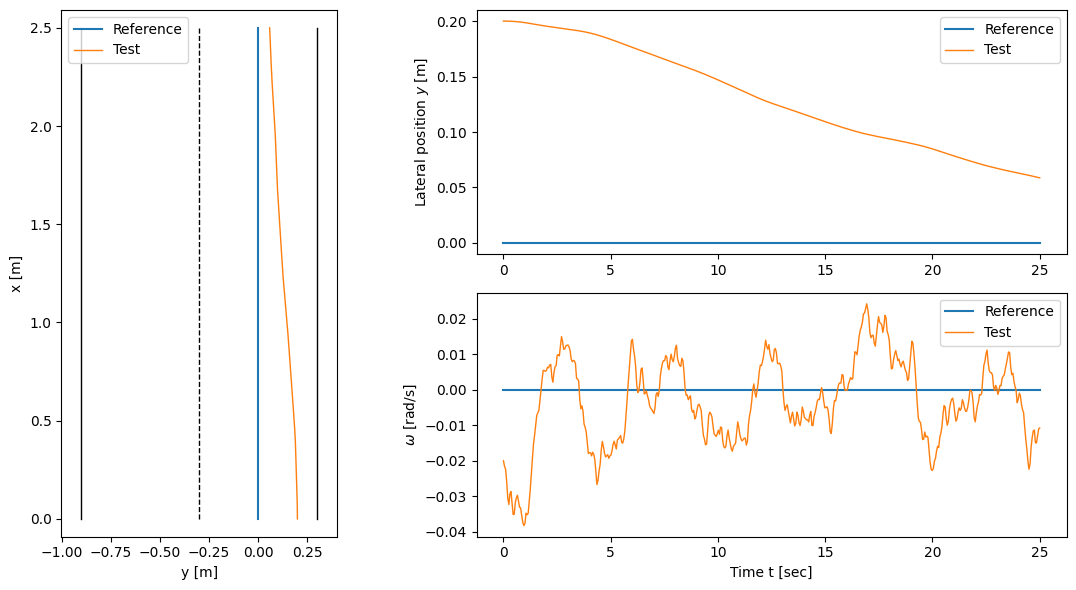

In [116]:
x_ref = x_curvy[0]
theta_ref = x_curvy[2]
omega_ref = w_curvy
y = np.array([yf])
omega = np.array([omegaf])

duckiebot.plot_track_multiple_controller(x_ref, y_ref, theta_ref, t, omega_ref, y, omega, ['Test'])

Feel free to go back to the exercises and try different $Q$ transfer-functions, poles and iniatial conidtions. Try and observe the effects these changes have on the system by analyzing the plot.

# Exercise 2: Frequency Weights

Pay attention, the last state in after augw is the error e. the states of plant P itself are not anymore there as shown in lecture

In [117]:
W1 = ct.TransferFunction([1], [1, 0.01],name='W1')
W3 = ct.TransferFunction([100, 1], [1, 1001],name='W3')
W2 = None
P = ct.TransferFunction([1], [1, -1],name='P')

general_ss = ct.augw(P,W1,W2,W3)
general_ss

StateSpace(array([[-1.000e-02,  0.000e+00, -1.000e+00],
       [ 0.000e+00, -1.001e+03,  1.000e+00],
       [ 0.000e+00,  0.000e+00,  1.000e+00]]), array([[1., 0.],
       [0., 0.],
       [0., 1.]]), array([[ 1.00000e+00,  0.00000e+00,  0.00000e+00],
       [ 0.00000e+00, -1.00099e+05,  1.00000e+02],
       [ 0.00000e+00,  0.00000e+00, -1.00000e+00]]), array([[0., 0.],
       [0., 0.],
       [1., 0.]]))